# Dat550 Project

In [81]:
from lxml import etree
import pandas as pd
import nltk
from collections import Counter
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as pyplot
import seaborn as sns   

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, Flatten , Embedding, Dense, Dropout, GlobalMaxPooling1D

In [82]:
# df = pd.read_xml("Webis-data/extracted/ground-truth-training-byarticle-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-byarticle.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-training-bypublisher-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-bypublisher-20181212.xml")
# df.to_json("preprocessing/data/ground-truth-test-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-byarticle-20181207.xml")
# df.to_json("preprocessing/data/ground-truth-test-byarticle.jsonl",orient="records",lines=True)


In [83]:
filepath = "preprocessing/data/articles-training-byarticle.jsonl"


def load_json(filepath):
    articles = []
    labels = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            text = data["title"] + " " + data["content"]
            label = data["hyperpartisan"]  # adjust if your label key is different
            articles.append(text)
            labels.append(label)
    return articles, labels

texts, labels = load_json(filepath)
# Encode labels (True/False -> 1/0)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [84]:
def get_ngrams(text, n=2, top_k = 100):
    vectorizer = CountVectorizer(ngram_range=(1,n),stop_words="english")
    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names_out()

    freq = np.array(X.sum(axis=0)).flatten()
    top_indices = freq.argsort()[-top_k:][::-1]
    return [(features[i], freq[i]) for i in top_indices]

texts = [article["text"] for article in articles]
ngrams = get_ngrams(texts)
print(ngrams)

[('trump', np.int64(2691)), ('said', np.int64(1393)), ('people', np.int64(1247)), ('clinton', np.int64(1139)), ('president', np.int64(1133)), ('just', np.int64(654)), ('hillary', np.int64(632)), ('like', np.int64(632)), ('police', np.int64(575)), ('white', np.int64(556)), ('new', np.int64(543)), ('obama', np.int64(540)), ('news', np.int64(537)), ('donald', np.int64(523)), ('donald trump', np.int64(501)), ('time', np.int64(495)), ('state', np.int64(485)), ('don', np.int64(465)), ('know', np.int64(452)), ('american', np.int64(433)), ('hillary clinton', np.int64(431)), ('america', np.int64(423)), ('right', np.int64(421)), ('twitter', np.int64(415)), ('left', np.int64(407)), ('did', np.int64(407)), ('man', np.int64(398)), ('media', np.int64(377)), ('country', np.int64(368)), ('year', np.int64(368)), ('house', np.int64(368)), ('fbi', np.int64(365)), ('think', np.int64(344)), ('going', np.int64(341)), ('say', np.int64(339)), ('women', np.int64(333)), ('years', np.int64(323)), ('world', np.in

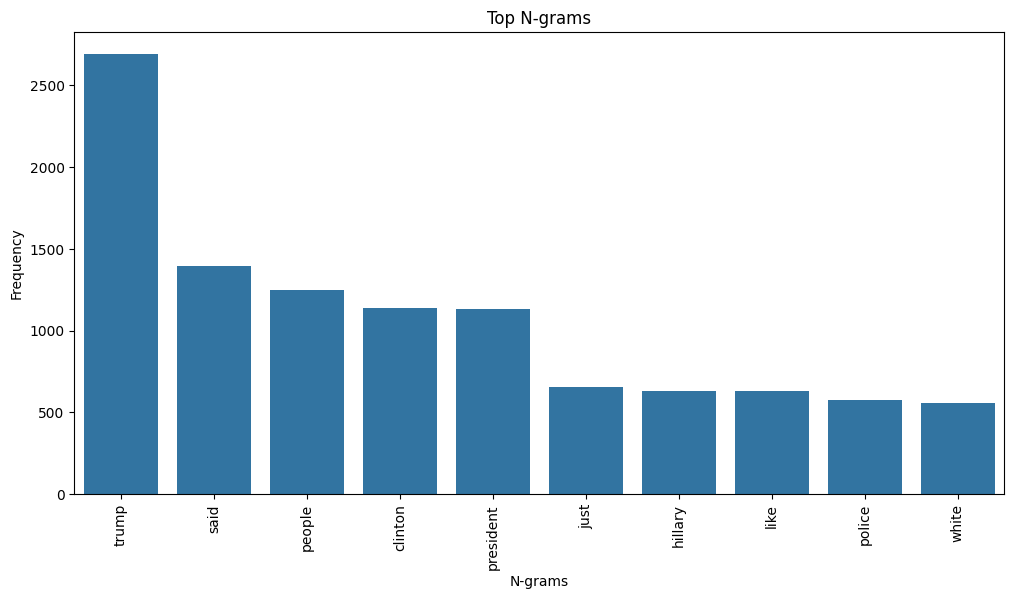

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_ngrams(ngrams):
    # Separate the n-grams and their frequencies
    ngram_labels, ngram_freqs = zip(*ngrams)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(ngram_labels), y=list(ngram_freqs))
    plt.xticks(rotation=90)
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.title('Top N-grams')
    plt.show()

# Plot the top 10 n-grams
plot_top_ngrams(ngrams[:10])



## Tensorflow Tokenizer


In [86]:
# Tokenize and pad sequences
max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train = np.array(padded)
y_train = np.array(labels)

In [87]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [89]:
# --- Compile the model ---
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 496, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,369 (5.23 MB)

 Trainable params: 1,370,369 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7220 - loss: 0.5570 - val_accuracy: 1.0000 - val_loss: 0.0519
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 6.5997e-04
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 2.5728e-04 - val_accuracy: 1.0000 - val_loss: 2.3497e-04
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 1.2044e-04 - val_accuracy: 1.0000 - val_loss: 1.9151e-04
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 5.7108e-05 - val_accuracy: 1.0000 - val_loss: 1.8012e-04


## Hyper-Partisan Matrix